<a href="https://colab.research.google.com/github/writeforfun/video-classification/blob/master/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install keras_metrics

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras_metrics as km
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.cluster import KMeans

data_dir = "/content/drive/My Drive/Colab Notebooks/UCF15"
img_height , img_width = 64, 64
seq_len = 30
 
UCF15 = os.listdir("/content/drive/My Drive/Colab Notebooks/UCF15")
classes = []
for item in UCF15:
  if item == ".DS_Store":
    pass
  else:
    classes.append(item)
classes = classes[0:5] 
classes

['Billiards', 'GolfSwing', 'BaseballPitch', 'HulaHoop', 'Fencing']

In [ ]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
          
    for c in classes:
        
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                X.append(frames)
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [ ]:
X, Y = create_data(data_dir)

In [ ]:
X.shape

(678, 30, 64, 64, 3)

In [ ]:
#把X轉成1D數據
X_anger = X.reshape(X.shape[0] ,seq_len, -1)
#特徵長度
features_len = X_anger.shape[2]
X_anger.shape

(678, 30, 12288)

In [ ]:
# define encoder
inputs = Input(shape=(seq_len,features_len))
encoded_X = LSTM(200, activation='relu')(inputs)
encoded_X = Dense(100, activation='relu')(encoded_X)
# define reconstruct decoder
decoded_X = RepeatVector(seq_len)(encoded_X)
dncoded_X = Dense(100, activation='relu')(decoded_X)
decoded_X = LSTM(200, activation='relu', return_sequences=True)(decoded_X)
decoded_X = TimeDistributed(Dense(features_len))(decoded_X)
#reshape output when video
model = Model(inputs=inputs, outputs=decoded_X)
model.compile(optimizer='adam', loss='mse')
#上面這整個model的前半encoder
Encoder = Model(inputs,encoded_X) #input, output1

In [ ]:
import keras.backend as K
print(K.eval(model.optimizer.lr))

0.001


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 12288)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               9991200   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           240800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 12288)         2469888   
Total params: 12,721,988
Trainable params: 12,721,988
Non-trainable params: 0
_______________________________________________

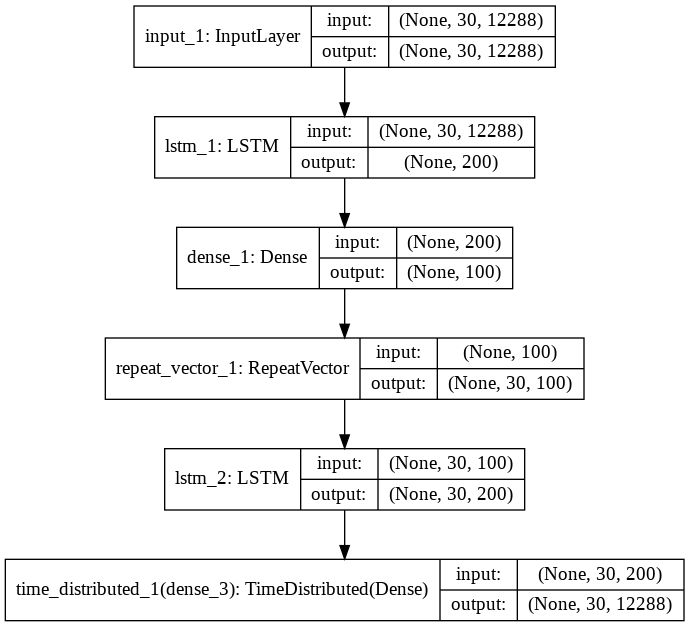

In [ ]:
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

In [ ]:
history = model.fit(X_anger, X_anger, epochs=20, verbose=1)

Epoch 1/20
678/678 [==============================] - 7s 10ms/step - loss: 10292821.0070
Epoch 2/20
678/678 [==============================] - 4s 6ms/step - loss: 14659911.6696
Epoch 3/20
678/678 [==============================] - 4s 6ms/step - loss: 4105338.9347
Epoch 4/20
678/678 [==============================] - 4s 6ms/step - loss: 1060347.7839
Epoch 5/20
678/678 [==============================] - 4s 6ms/step - loss: 1711461.2426
Epoch 6/20
678/678 [==============================] - 4s 6ms/step - loss: 1166297.6840
Epoch 7/20
678/678 [==============================] - 4s 6ms/step - loss: 1309446.2247
Epoch 8/20
678/678 [==============================] - 4s 6ms/step - loss: 315018.4475
Epoch 9/20
678/678 [==============================] - 4s 6ms/step - loss: 167060.0279
Epoch 10/20
678/678 [==============================] - 4s 6ms/step - loss: 94168.8254
Epoch 11/20
678/678 [==============================] - 4s 6ms/step - loss: 41874.2053
Epoch 12/20
678/678 [=======================

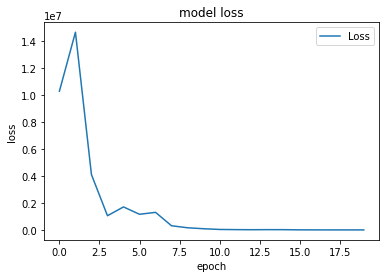

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss'], loc='best')
plt.show()

In [ ]:
x_test_encoded = Encoder.predict(X_anger)
x_test_encoded.shape

(678, 100)

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd                     
pca = PCA(n_components=2)  # 把維度降至2維
# 進行PCA降維
X_pca = pca.fit_transform(x_test_encoded)
# 生成降維後的dataframe
X_pca_frame = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2'])  
X_pca_frame.head()


,pca_1,pca_2
0,-137723.812500,67336.843750
1,-140485.031250,82801.648438
2,-151647.062500,49015.406250
3,253325.500000,-14676.313477
4,-146516.828125,46733.937500


In [ ]:
#看PCA1,PCA2...的比率
pca.explained_variance_ratio_

array([0.62982404, 0.13172498], dtype=float32)

In [ ]:
Y2 = Y.copy()
#one-hot to integer
Y2 = np.array([np.where(r==1)[0][0] for r in Y2])


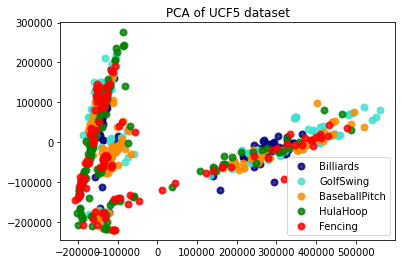

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange','green','red']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], np.array(classes)):
    plt.scatter(X_pca[Y2 == i, 0], X_pca[Y2 == i, 1], color=color, alpha=.8, lw=lw,# Y2要numpy array
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of UCF5 dataset')
plt.show()

calinski_harabaz_score with k=5 is 3055.8876034204795
calinski_harabaz_score with k=6 is 2983.150814300932
calinski_harabaz_score with k=7 is 2996.2323692606883
calinski_harabaz_score with k=8 is 3128.379939057934


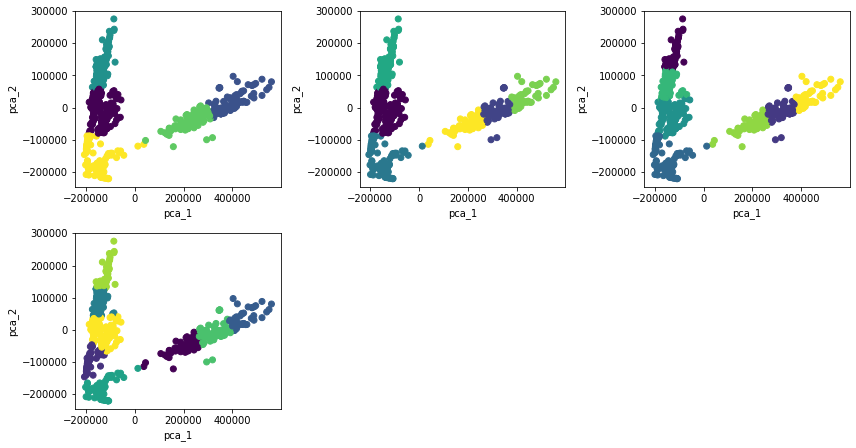

In [ ]:
from sklearn import metrics
d = {}
fig_reduced_data = plt.figure(figsize=(12, 12)) #畫圖之前先設置figure，此函数=設置一塊自定義大小的畫布讓之後的圖形印在這塊畫布上
for k in range(5, 9):
    est = KMeans(n_clusters=k, random_state=111)
    y_pred = est.fit_predict(X_pca) #作用到降維後的數據上
    # ====評估不同k值效果====

    # X_pca_frame：表示要cluster的樣本數據，一般如（samples，features）的格式。y_pred：即cluster後得到的label，如（samples，）的格式
    calinski_harabaz_score = metrics.calinski_harabasz_score(X_pca_frame, y_pred)  
    d.update({k: calinski_harabaz_score})
    print('calinski_harabaz_score with k={0} is {1}'.format(k, calinski_harabaz_score))  # CH score的数值越大越好
    #生成2D圖，每個樣本點的坐標分别是兩個主成分的值
    ax = plt.subplot(4, 3, k-1) #將設置的畫布大小分成幾個部分，表示4(row)x3(col),k-4表示選擇圖形輸出的區域在第k-1塊，參數必須在“rowXcol”範圍
    ax.scatter(X_pca_frame.pca_1, X_pca_frame.pca_2, c=y_pred)  # pca_1、pca_2為輸入數據，c表示顏色序列
    ax.set_xlabel('pca_1')
    ax.set_ylabel('pca_2')
    plt.tight_layout()